<div style='color:white;font-size:30px;background-color:#196363;text-align:center;padding-top:20px; padding-bottom:20px;margin-bottom:40px'>VERSIFICATION & AUTHORSHIP ATTRIBUTION</div>

<h1>4.1 The Two Noble Kinsmen</h1>
<h2 style='margin-bottom: 50px'>Replication code</h2>

In [17]:
import random
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from collections import Counter
from collections import defaultdict
from scipy.stats import zscore
from sklearn.svm import SVC

<h3>Read data from JSON</h3>

In [2]:
#-----------------------------------------------------------------------------------------#
# the file contains a list of scenes each of them being a dict with following structure:  #   
# {                                                                                       #
#     'author': string ('Shakespeare', 'Fletcher', 'target'),                             #
#     'play': string ('Coriolanus', 'Cymbeline'...),                                      #
#     'id': string ('1.1', '1.2'...),                                                     #
#     'lines': [                                                                          #
#         'words': list (~ list of words in the line),                                    #
#         'stress': string (~ bitstring representing rhythmic type),                      #
#     ]                                                                                   #
# }                                                                                       #
# Dataset comes from EarlyPrint project (http://earlyprint.org), rhythmical annotation    #
# was provided by Prosodic python package (https://github.com/quadrismegistus/prosodic)   #
#-----------------------------------------------------------------------------------------#

with open('data/tnk.json', 'r') as f:
    data = json.load(f)

# Remove scenes having less than 100 lines 
data = [x for x in data if len(x['lines']) >= 100]

<h2>4.1.2 Attribution of particular scenes</h2>

In [3]:
# Count number of lines and number of words in each scene
# (store word counts for further use)
words_count_scenes = list() 
for scene in data:
    lines_count = len(scene['lines'])
    words_count = 0
    for line in scene['lines']:
        for word in line['words']:
            words_count += 1
    words_count_scenes.append(words_count)
    print(scene['play'], scene['author'], scene['id'], lines_count, words_count)

Coriolanus Shakespeare 1.1 612 4541
Coriolanus Shakespeare 2.1 390 2843
Coriolanus Shakespeare 3.1 589 4325
Coriolanus Shakespeare 4.1 433 3273
Coriolanus Shakespeare 5.1 516 3983
Cymbeline Shakespeare 1.2 128 865
Cymbeline Shakespeare 1.7 226 1585
Cymbeline Shakespeare 2.3 124 946
Cymbeline Shakespeare 2.4 214 1510
Cymbeline Shakespeare 3.3 111 918
Cymbeline Shakespeare 3.4 199 1478
Cymbeline Shakespeare 3.5 128 908
Cymbeline Shakespeare 4.2 441 3204
Cymbeline Shakespeare 5.4 110 924
Cymbeline Shakespeare 5.5 508 3690
Valentinian Fletcher 1.1 128 989
Valentinian Fletcher 1.2 200 1519
Valentinian Fletcher 1.3 275 2093
Valentinian Fletcher 2.2 105 638
Valentinian Fletcher 2.3 138 996
Valentinian Fletcher 2.4 306 1882
Valentinian Fletcher 3.1 543 4170
Valentinian Fletcher 3.2 191 1568
Valentinian Fletcher 4.1 230 1693
Valentinian Fletcher 4.4 429 3162
Valentinian Fletcher 5.2 202 1347
Valentinian Fletcher 5.8 128 969
Monsieur Thomas Fletcher 1.1 190 1348
Monsieur Thomas Fletcher 1.2 166 

<h3>Scenes to vectors</h3>

In [4]:
most_frequent = {'stress': [], 'words': []}
frequencies = {'stress': [], 'words': []}

# Iterate over scenes and add each rhythmic type and word to overall list
for scene in data:
    if scene['play'] == 'Two Noble Kinsmen': # skip the target text
        continue
    for line in scene['lines']:
        most_frequent['stress'].append(line['stress'])
        for word in line['words']:
            most_frequent['words'].append(word)
        
# Extract 500 most frequent rhythmic types and 500 most frequent words
for m in most_frequent:
    c = Counter(most_frequent[m])
    most_frequent[m] = [ x[0] for x in c.most_common(500) ]    

# Iterate over scenes and count the frequencies of 500 most frequent words and 
# 500 most frequent rhythmic types in particular scenes
for i, scene in enumerate(data):
    f = {'words':defaultdict(int), 'stress': defaultdict(int)}

    for line in scene['lines']:
        if line['stress'] in most_frequent['stress']:                
            f['stress'][line['stress']] += 1/len(scene['lines'])
        for word in line['words']:
            if word in most_frequent['words']:      
                f['words'][word] += 1/words_count_scenes[i]
    for t in f:
        frequencies[t].append(f[t])
    
# Store frequencies into dataframes
index = pd.MultiIndex.from_tuples([(x['author'], x['play'], x['id']) for x in data], 
                                  names=['author', 'play', 'scene'])
df = dict()
df['stress'] = pd.DataFrame(frequencies['stress'], index=index).fillna(0)
df['words'] =  pd.DataFrame(frequencies['words'], index=index).fillna(0)
df['combined'] = pd.concat([df['stress'], df['words']], axis=1)

<h3>Cross-validation</h3>

In [5]:
def extract_test_set(df, current_play):
    '''
    Extract test set (single play) from the dataframe
    [arg] df            = dataframe
    [arg] current_play  = title of the play which is
    [out] test_vectors  = list of vectors representing individual scenes
    [out] test_class    = actual author of the play
    [out] test_labels   = labels for output (author: play(scene))
    '''

    test_data = df.iloc[df.index.get_level_values('play') == current_play]
    test_vectors = test_data.values.tolist()
    test_class = test_data.index.get_level_values('author').unique().tolist()[0]
    test_labels = ['{0}: {1}({2})'.format(author, play, scene) for author, play, scene in test_data.index.tolist()]
    return test_vectors, test_class, test_labels


def extract_train_set(df, current_play=None):
    '''
    Extract training set from the dataframe
    [arg] df            = dataframe
    [arg] current_play  = title of the play to exclude from the training set (optional)
    [out] train_vectors = list of vectors representing individual scenes
    [out] train_classes = actual authors of individual scenes
    [out] level_to      = minimum of scenes by one author
    '''

    train_data = df.iloc[df.index.get_level_values('play') != current_play]
    train_vectors = train_data.values.tolist()
    train_classes = train_data.index.get_level_values('author').tolist()
    level_to = min(Counter(train_classes).values())    
    return train_vectors, train_classes, level_to

def classify(train_vectors, train_classes, test_vectors, level_to, allow_probs=False):
    '''
    Train the model and perform classification
    [arg] train_vectors = list of training vectors
    [arg] train_classes = actual authors of training samples
    [arg] test_vectors  = list of vectors to be classified
    [arg] level_to      = minimum of scenes by one author
    [out] predicted     = list of classification results 
    '''
    
    # Extract scene indices for each author
    authors_indices = defaultdict(list)
    for i, author in enumerate(train_classes):
        authors_indices[author].append(i)
    leveled_indices = list()

    # Level the number of training data by random
    for author in authors_indices:
        leveled_indices.extend(random.sample(authors_indices[author], level_to))
    train_vectors_leveled = [x for i,x in enumerate(train_vectors) if i in leveled_indices]
    train_classes_leveled = [x for i,x in enumerate(train_classes) if i in leveled_indices]

    # Fit the classifier to training data
    if allow_probs:
        clf = SVC(kernel='linear', C=1, probability=True)
    else:
        clf = SVC(kernel='linear', C=1)        
    clf.fit(train_vectors_leveled, train_classes_leveled)
            
    # Perform classification of test set
    predicted = clf.predict(test_vectors)  
    
    if allow_probs:
        probs = clf.predict_proba(test_vectors)
        return predicted, probs, clf.classes_
    else:
        return predicted
    
# Z-scores transformation of training data
dfz = dict()
for f in df:
    dfz[f] = df[f].loc[['Shakespeare', 'Fletcher']].apply(zscore)

# Get play titles
play_titles = dfz['stress'].index.get_level_values('play').unique().tolist()

# Container for cross-validation results
cv_results = defaultdict(lambda: defaultdict(int))

# Iterate over plays
for current_play in play_titles:

    # Iterate over feature sets (stress, word, combined)
    for f in dfz:

        # Extract training and test sets
        test_vectors, test_class, test_labels = extract_test_set(dfz[f], current_play)
        train_vectors, train_classes, level_to = extract_train_set(dfz[f], current_play)

        # Perform 30 random iterations
        for iteration in range(30):

            # Train the model and classify test set
            predicted = classify(train_vectors, train_classes, test_vectors, level_to)
            
            # Store classification result for each scene
            for i,p in enumerate(predicted):
                if p == test_class:
                    cv_results[test_labels[i]][f] += 1
                else:
                    cv_results[test_labels[i]][f] += 0

In [6]:
# Print results of cross-validation (number of correct classifications for each scene provided by models
# based on (1) rhythmic types, (2) words, (3) combined vectors)                    
for scene in sorted(cv_results):
    print(scene, cv_results[scene]['stress'], cv_results[scene]['words'], cv_results[scene]['combined'])

Fletcher: Bonduca(1.1) 30 30 30
Fletcher: Bonduca(1.2) 30 30 30
Fletcher: Bonduca(2.1) 27 30 30
Fletcher: Bonduca(2.2) 30 30 30
Fletcher: Bonduca(2.3) 30 30 30
Fletcher: Bonduca(2.4) 30 30 30
Fletcher: Bonduca(3.2) 30 30 30
Fletcher: Bonduca(3.5) 30 30 30
Fletcher: Bonduca(4.2) 30 30 30
Fletcher: Bonduca(4.3) 30 30 30
Fletcher: Bonduca(4.4) 30 30 30
Fletcher: Bonduca(5.1) 30 2 29
Fletcher: Bonduca(5.2) 30 30 30
Fletcher: Bonduca(5.3) 30 30 30
Fletcher: Monsieur Thomas(1.1) 30 30 30
Fletcher: Monsieur Thomas(1.2) 30 29 30
Fletcher: Monsieur Thomas(1.3) 30 30 30
Fletcher: Monsieur Thomas(2.3) 30 30 30
Fletcher: Monsieur Thomas(2.5) 30 30 30
Fletcher: Monsieur Thomas(3.1) 30 30 30
Fletcher: Monsieur Thomas(3.3) 30 30 30
Fletcher: Monsieur Thomas(4.1) 30 30 30
Fletcher: Monsieur Thomas(4.2) 30 30 30
Fletcher: Monsieur Thomas(5.12) 30 30 30
Fletcher: Valentinian(1.1) 30 30 30
Fletcher: Valentinian(1.2) 30 30 30
Fletcher: Valentinian(1.3) 30 30 30
Fletcher: Valentinian(2.2) 30 30 30
Fletcher

In [7]:
# Print results of cross-validation as a portion of correct classifications per play
cv_results_per_play = defaultdict(lambda: defaultdict(list))

for scene in sorted(cv_results):
    play_title = re.sub('\(.*$', '', scene)
    for f in cv_results[scene]:
        cv_results_per_play[play_title][f].append(cv_results[scene][f])
        
for play in sorted(cv_results_per_play):
    for f in cv_results_per_play[play]:
        cv_results_per_play[play][f] = sum(cv_results_per_play[play][f]) / (len(cv_results_per_play[play][f])*30)
    print(play, cv_results_per_play[play]['stress'], 
          cv_results_per_play[play]['words'], cv_results_per_play[play]['combined'])

Fletcher: Bonduca 0.9928571428571429 0.9333333333333333 0.9976190476190476
Fletcher: Monsieur Thomas 1.0 0.9966666666666667 1.0
Fletcher: Valentinian 0.9833333333333333 1.0 0.9972222222222222
Fletcher: Woman's Prize 1.0 1.0 1.0
Shakespeare: Coriolanus 1.0 1.0 1.0
Shakespeare: Cymbeline 1.0 1.0 1.0
Shakespeare: Tempest 1.0 1.0 1.0
Shakespeare: Winter's Tale 1.0 1.0 1.0


<h3>Classification of TNK</h3>

In [8]:
# Z-scores transformation of all data
dfz = dict()
for f in df:
    dfz[f] = df[f].apply(zscore)

# Get play titles
play_titles = dfz['combined'].index.get_level_values('play').unique().tolist()

# Iterate over feature sets
for f in dfz:
    print('='*40, f)

    # Container for classification results
    tnk_results = defaultdict(lambda: defaultdict(int))

    # Extract training and test sets
    test_vectors, test_class, test_labels = extract_test_set(dfz[f], 'Two Noble Kinsmen')
    train_vectors, train_classes, level_to = extract_train_set(dfz[f], 'Two Noble Kinsmen')

    # Perform 30 random iterations
    for iteration in range(30):

        # Perform, classification of test set
        predicted = classify(train_vectors, train_classes, test_vectors, level_to)

        # Store classification result for each scene
        for i,p in enumerate(predicted):
            tnk_results[test_labels[i]][p] += 1

    # Print results
    for scene in sorted(tnk_results):
        print(scene)
        for author in tnk_results[scene]:
            print('\t', author, tnk_results[scene][author])

======================================== combined
target: Two Noble Kinsmen(1.1)
	 Shakespeare 30
target: Two Noble Kinsmen(1.2)
	 Shakespeare 30
target: Two Noble Kinsmen(1.3)
	 Shakespeare 30
target: Two Noble Kinsmen(2.2)
	 Fletcher 30
target: Two Noble Kinsmen(3.1)
	 Shakespeare 30
target: Two Noble Kinsmen(3.6)
	 Fletcher 30
target: Two Noble Kinsmen(4.1)
	 Shakespeare 27
	 Fletcher 3
target: Two Noble Kinsmen(4.2)
	 Fletcher 30
target: Two Noble Kinsmen(5.1)
	 Shakespeare 30
target: Two Noble Kinsmen(5.2)
	 Fletcher 30
target: Two Noble Kinsmen(5.3)
	 Shakespeare 30
target: Two Noble Kinsmen(5.4)
	 Shakespeare 30
======================================== stress
target: Two Noble Kinsmen(1.1)
	 Shakespeare 30
target: Two Noble Kinsmen(1.2)
	 Shakespeare 30
target: Two Noble Kinsmen(1.3)
	 Shakespeare 30
target: Two Noble Kinsmen(2.2)
	 Fletcher 30
target: Two Noble Kinsmen(3.1)
	 Shakespeare 30
target: Two Noble Kinsmen(3.6)
	 Fletcher 27
	 Shakespeare 3
target: Two Noble Kinsmen(4

<h2>4.1.3 Rolling attribution of the play</h2>

<h3>Extract samples</h3>

In [14]:
# Read data from JSON once again (to get the removed short scenes back)
with open('data/tnk.json', 'r') as f:
    data = json.load(f)

# Merge the scenes of each play into single list
plays_merged = defaultdict(list)
plays_authors = dict()
for i, scene in enumerate(data):
    if scene['author'] == 'Massinger':
        continue
    plays_merged[scene['play']].extend(scene['lines'])
    plays_authors[scene['play']] = scene['author']

# Count frequencies in rolling samples
index1 = list()
index2 = list()
frequencies_samples = {'stress': [], 'words': []}
frequencies_rolling = {'stress': [], 'words': []}

# Iterate over plays
for play in plays_merged:    
    i = 0
    # Iterate over 100-lines long overlapping samples
    while i <= len(plays_merged[play]) - 100:

        # Extract the sample from the play
        frame = plays_merged[play][i:i+100]

        # Count frequencies in the sample
        index2.append((plays_authors[play], play+'_rolling', (i+5)/5))
        f_rolling = {'words':defaultdict(int), 'stress': defaultdict(int)}
        n = 0
        for line in frame:
            if line['stress'] in most_frequent['stress']:                
                f_rolling['stress'][line['stress']] += 1/len(frame)
            for word in line['words']:
                if word in most_frequent['words']:      
                    f_rolling['words'][word] += 1  
                n += 1

        # Word counts into relative frequencies
        for word in f_rolling['words']:
            f_rolling['words'][word] /= n

        # Store frequencies into main container of overlapping samples
        for t in f_rolling:
            frequencies_rolling[t].append(f_rolling[t])

        # If sample index % 20: store frequencies into main container of non-overlapping samples
        if i % 100 == 0 and play != 'Two Noble Kinsmen':
            index1.append((plays_authors[play], play, (i+20)/20))
            for t in f_rolling:
                frequencies_samples[t].append(f_rolling[t])
        i += 5
        
# Store frequencies into dataframes (non-overlapping samples)
index1 = pd.MultiIndex.from_tuples(index1, names=['author', 'play', 'scene'])
dfr1 = dict()
dfr1['stress'] = pd.DataFrame(frequencies_samples['stress'], index=index1).fillna(0)
dfr1['words'] =  pd.DataFrame(frequencies_samples['words'], index=index1).fillna(0)
dfr1['combined'] = pd.concat([dfr1['stress'], dfr1['words']], axis=1)

# Store frequencies into dataframes (overlapping samples)
index2 = pd.MultiIndex.from_tuples(index2, names=['author', 'play', 'scene'])
dfr2 = dict()
dfr2['stress'] = pd.DataFrame(frequencies_rolling['stress'], index=index2).fillna(0)
dfr2['words'] =  pd.DataFrame(frequencies_rolling['words'], index=index2).fillna(0)
dfr2['combined'] = pd.concat([dfr2['stress'], dfr2['words']], axis=1)

<h3>Apply to training set and to TNK</h3>

In [15]:
# Get play titles
play_titles = dfr1['combined'].index.get_level_values('play').unique().tolist()

# Container for results
rolling_results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for current_play in play_titles + ['Two Noble Kinsmen']:

    for f in dfr1:
        print(current_play, f)        

        # Get play titles
        dfr1b = dfr1[f].loc[['Shakespeare', 'Fletcher']]
        play_titles = dfr1b.index.get_level_values('play').unique().tolist()

        rr = defaultdict(lambda: defaultdict(list))

        # Concat the df with rolling samples from the play, trasform values to z-scores and remove rows on current_play
        dfr = pd.concat([dfr1b,dfr2[f].iloc[dfr2[f].index.get_level_values('play') == current_play+'_rolling']])
        dfz = dfr.apply(zscore)
        dfz = dfz.iloc[dfz.index.get_level_values('play') != current_play]

        # Extract training and test sets
        train_vectors, train_classes, level_to = extract_train_set(dfz, current_play+'_rolling')
        test_vectors, test_class, test_labels = extract_test_set(dfz, current_play+'_rolling')

        train_vectors = [train_vectors[i] for i,x in enumerate(train_classes) if x != 'Massinger']
        train_classes = [x for i,x in enumerate(train_classes) if x != 'Massinger']

        # Perform 30 random iterations
        for iteration in range(30):

            # Train the model and classify rolling samples
            predicted, probs, classes = classify(train_vectors, train_classes, test_vectors, level_to, allow_probs=True)

            # Store the results
            for i,x in enumerate(probs):
                for c in (0,1):
                    for j in range(20):
                        if classes[c] == 'Shakespeare':
                            rr[classes[c]][i+j].append(x[c]) 
                        else:
                            rr[classes[c]][i+j].append((-1) * x[c])

        # Count the average probability for each 5-lines sequence                        
        for c in rr:
            for i in sorted(rr[c]):
                rolling_results[current_play][f][c].append(sum(rr[c][i])/len(rr[c][i]))      
                if c == 'Shakespeare':
                    line_val = (
                        (
                            ( 
                                sum(rr['Shakespeare'][i])/len(rr['Shakespeare'][i])
                            ) + (
                                sum(rr['Fletcher'][i])/len(rr['Fletcher'][i])
                            )
                        )/2
                    )
                    rolling_results[current_play][f]['line'].append(line_val)    

Bonduca combined
Bonduca stress
Bonduca words
Winter's Tale combined
Winter's Tale stress
Winter's Tale words
Monsieur Thomas combined
Monsieur Thomas stress
Monsieur Thomas words
Coriolanus combined
Coriolanus stress
Coriolanus words
Valentinian combined
Valentinian stress
Valentinian words
Woman's Prize combined
Woman's Prize stress
Woman's Prize words
Tempest combined
Tempest stress
Tempest words
Cymbeline combined
Cymbeline stress
Cymbeline words
Two Noble Kinsmen combined
Two Noble Kinsmen stress
Two Noble Kinsmen words


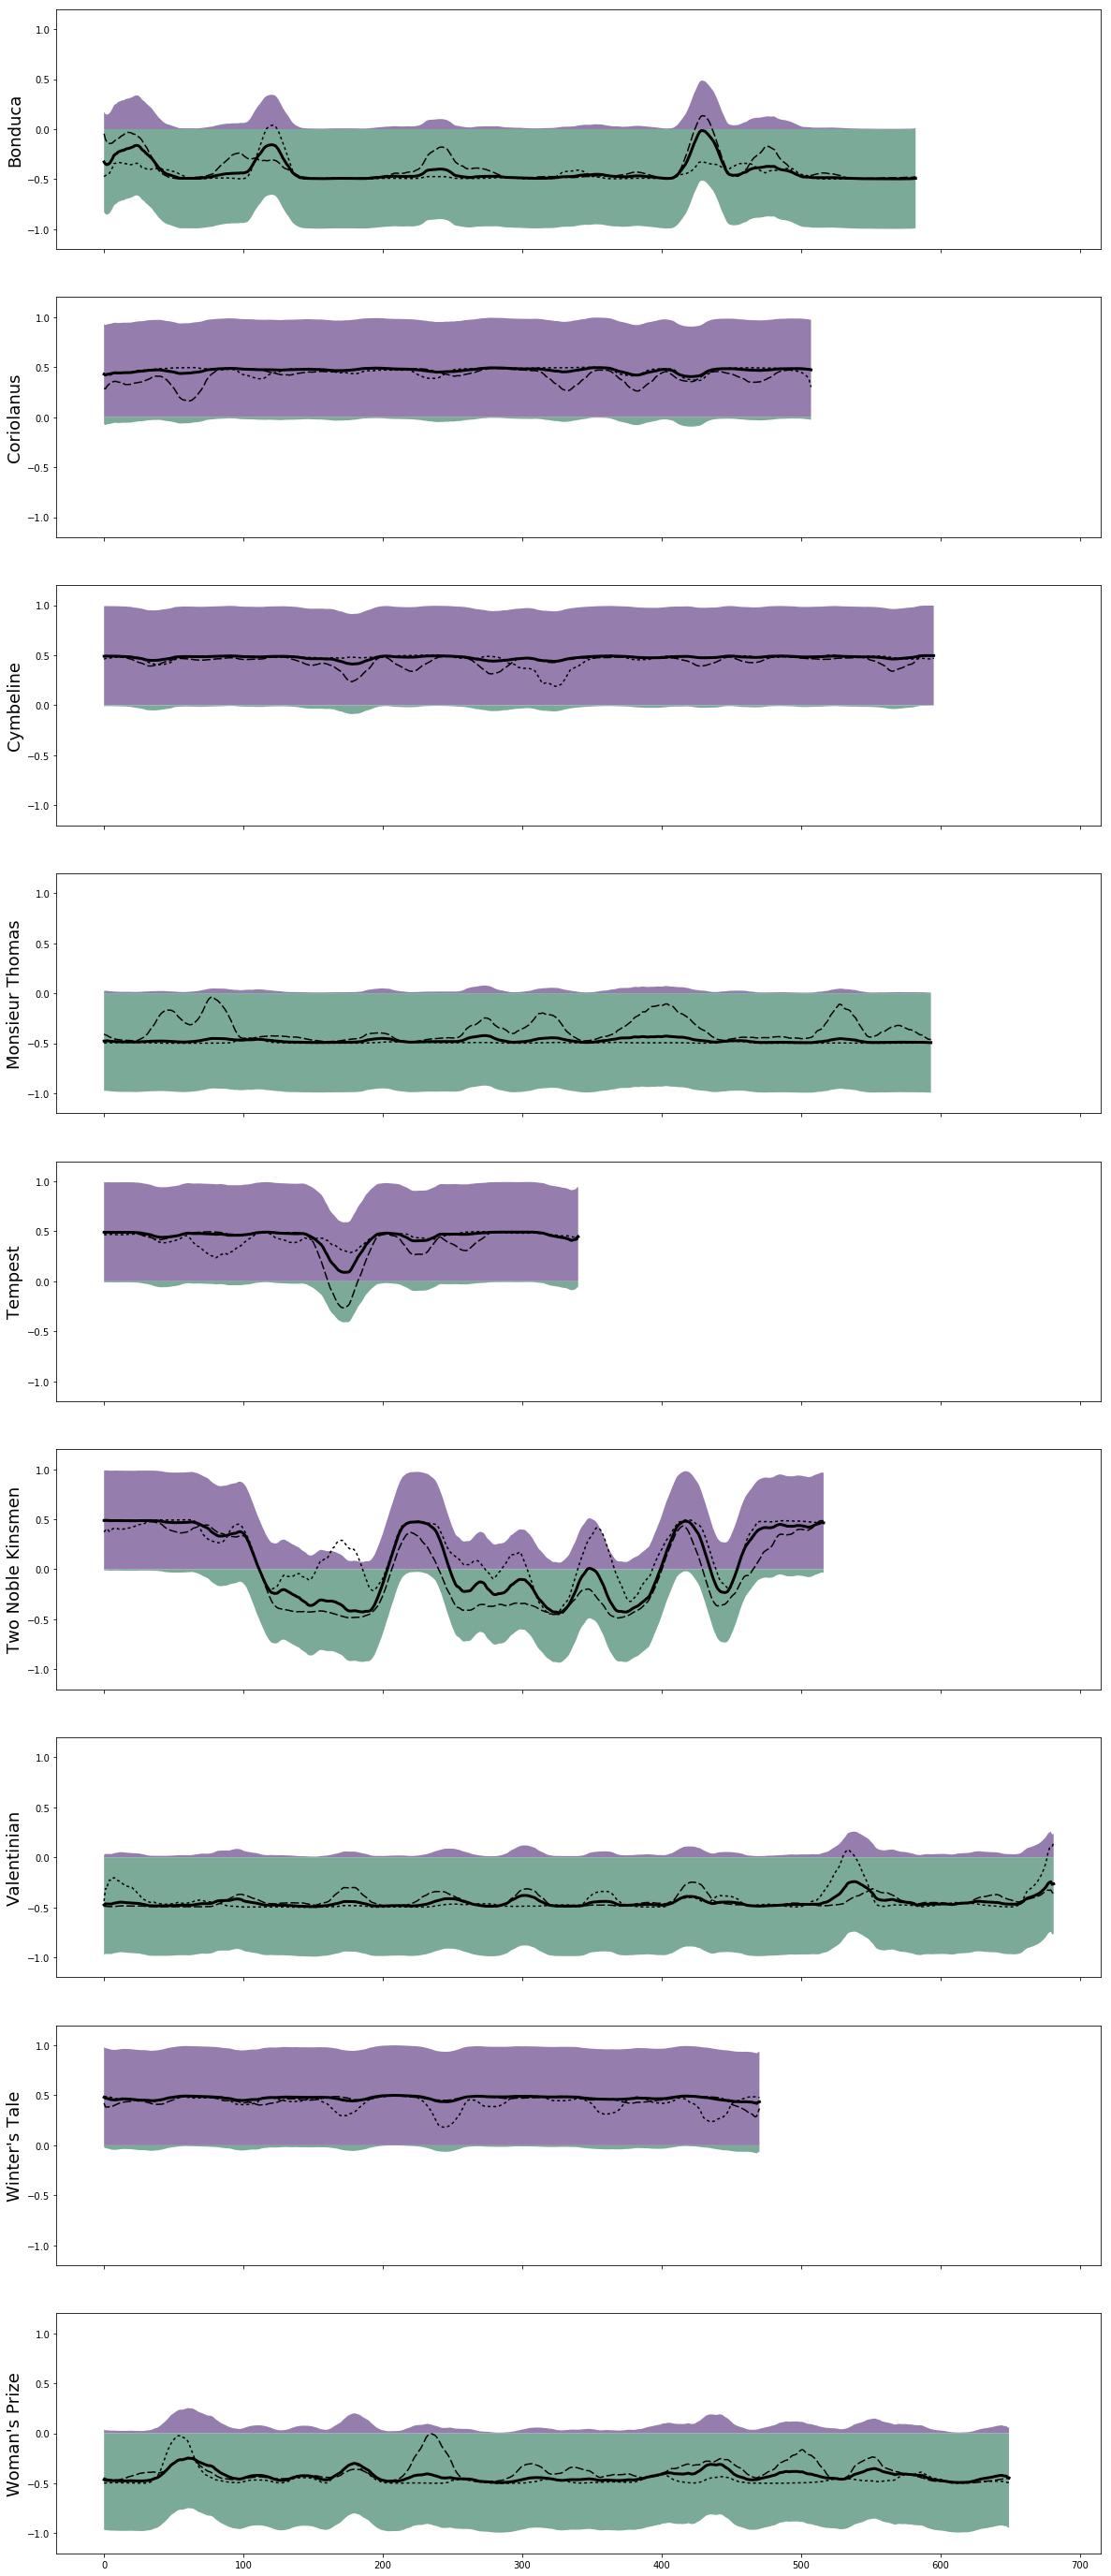

In [16]:
# Plot the charts
ax = [None] * len(rolling_results)
fig, ax = plt.subplots(len(ax), 1, sharex=True, figsize=(20, 50))

i = 0
for play in sorted(rolling_results):
    x = range(len(rolling_results[play]['combined']['Shakespeare']))
    ax[i].fill_between(x, 0, rolling_results[play]['combined']['Shakespeare'], facecolor='#957DAD', interpolate=True)
    ax[i].fill_between(x, 0, rolling_results[play]['combined']['Fletcher'], facecolor='#7CAA98', interpolate=True)
    ax[i].plot(x, rolling_results[play]['combined']['line'], color='black', linewidth=3)
    ax[i].plot(x, rolling_results[play]['stress']['line'], color='black', dashes=[2,2])
    ax[i].plot(x, rolling_results[play]['words']['line'], color='black', dashes=[6,2])    
    ax[i].set_ylim(-1.2,1.2)
    ax[i].set_ylabel(play, fontsize=18)              
    i += 1